# Projection des tombes disponibles dans la base de données sur une image de la nécropole de Kerma


La nécropole de Kerma ([Image satellite Google Maps](https://www.google.com/maps/@19.6011847,30.410146,363m/data=!3m1!1e3)) est représentée sur une image au format jpg comprenant 10659 × 15362 pixels (carte_necropole.jpg) mise à disposition par le prof. Matthieu Honegger.

L'image représente la quadrillage du site fouillé, avec un point central et des distances selon les axes Est-Ouest et Nord-Sud exprimées en mètres. Dans la base de données les tombes sont positionnées par des coordonnées exprimées dans le même système de quadrillage. La tâche consiste donc à projeter les tombes sur l'image tout en tirant profit du quadrillage qui permet de se répérer.

Pour ce faire, nous utilisons les fonctionnalités mises à disposition par la librairie [Matplotlib](https://matplotlib.org) en nous inspirant de [cet exemple](https://www.geeksforgeeks.org/plot-a-point-or-a-line-on-an-image-with-matplotlib/) de projection de points et lignes sur une photo. Nous procédons ainsi:
* nous trouvons d'abord les coordonnées en pixels du point 0,0 du quadrillage (par projection d'un point sur la carte et approchage progressif)
* ensuite il faut trouver le rapport numérique entre pixels et distances en mètres depuis le point 0,0
* ce rapport est lui aussi obtenu par approximation progressive en utilisant une ligne verticale qui va se positionner correctement sur l'image
    * noter que le rapport est légèrement différent à l'horizontale et à la verticale: vx = 9.88 vy = 9.85
    * noter aussi que la superposition des tombes des données sur celles de l'image est améliorée avec un rapport vx = 9.95
* l'image qui résulte de la projection est sauvegardée au format .svg – ce qui permet de l'ouvrir dans un navigateur web et de l'inspecter en agrandissant à loisir
* on dispose ainsi de tous les éléments qui permettent ensuite de situer les tombes sur la carte de la nécropole
* la surface des points représentant les tombes est calculée en proportion à leur surface
* on calculera les _bounding boxes_ élargie des secteurs et on les projetera également pour vérifier la cohérence entre la carte et les données


In [66]:
from matplotlib import image
from matplotlib import pyplot as plt
import sqlite3 as sql
import pandas as pd

### Exemples des fonctions de construction de géométries dans la librairie Matplotlib

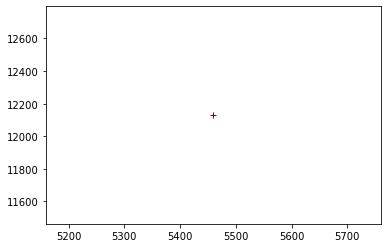

In [260]:
### Le point utilisé pour trouver les coordonnées 0,0 dans la photo ci-dessous:
# Il a été trouvé par exécution progressive du script jusqu'au positionnement correct sur le point 0,0
plt.plot(5460, 12130, marker='+', color="DarkRed")

(2558, 1296) 415 581


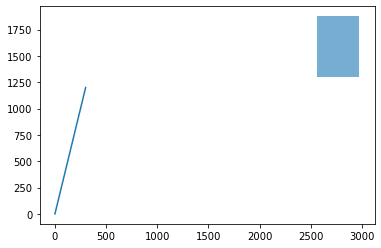

<Figure size 1440x2160 with 0 Axes>

In [261]:
### Construction de lignes et réctangles à partir de points-coordonnées correspondant aux pixels
# https://www.statology.org/matplotlib-rectangle/
fig, ax = plt.subplots()
plt.figure(figsize = (20,30)) 
from matplotlib.patches import Rectangle
ax.plot([0,300], [0,1200])
rect = rectangles[0] 
print(rect[0], rect[1], rect[2])
ax.add_patch(Rectangle(rect[0], rect[1], rect[2], alpha = 0.6))

In [262]:
### mettre l'image en variable
im = image.imread('documentation/carte_necropole.jpg')

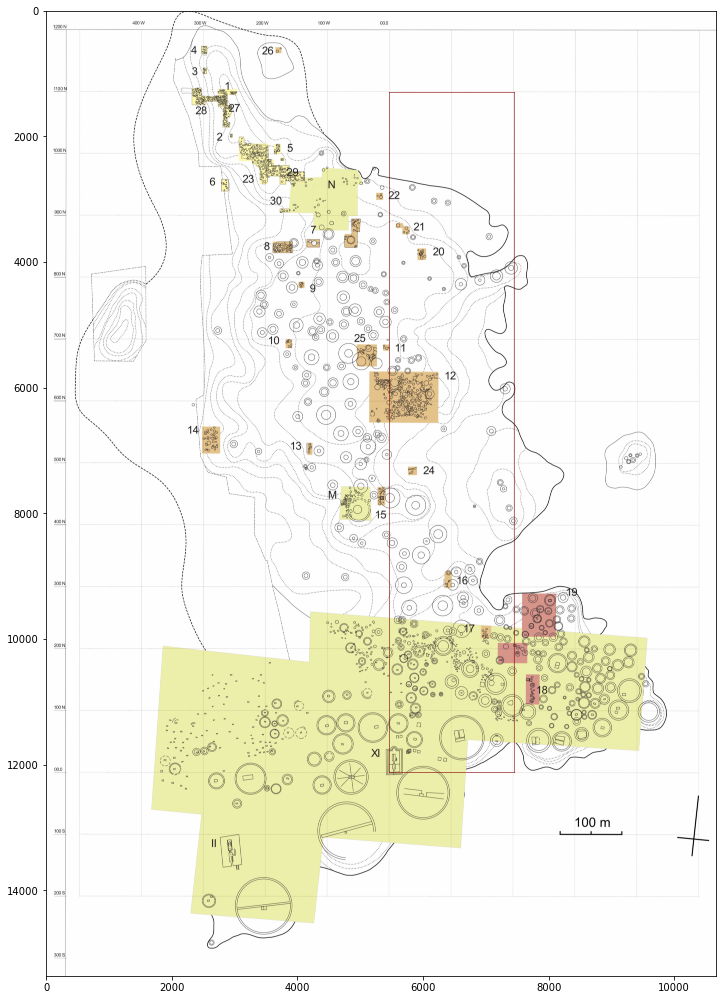

In [300]:
plt.figure(figsize = (12,18))  # (12,18)

x0 = 5465
y0 = 12120

vx = 9.88
vy = 9.85

# ligne horizontale Sud
xEW1 = [x0 + 200 * vx, x0]
yEW1 = [y0, y0]

# ligne horizontale Nord
xEW2 = [x0 + 200 * vx, x0]
yEW2 = [y0 - 1100 * vy, y0 - 1100 * vy]

# ligne verticale Ouest
xNS1 = [x0 + 200 * vx, x0 + 200 * vx]
yNS1 = [y0, y0 - 1100 * vy]

# ligne verticale Est
xNS2 = [x0, x0]
yNS2 = [y0, y0 - 1100 * vy]


plt.plot(xNS1, yNS1, color="DarkRed", linewidth=0.7, alpha=0.8)

plt.plot(xEW1, yEW1, color="DarkRed", linewidth=0.7, alpha=0.8)
    
plt.plot(xNS2, yNS2, color="DarkRed", linewidth=0.7, alpha=0.8)

plt.plot(xEW2, yEW2, color="DarkRed", linewidth=0.7, alpha=0.8)
        
    
    
    
implot = plt.imshow(im)

# plt.savefig('documentation/carte_necropole_avec_tombes.jpg', format='jpg')
plt.savefig('documentation/carte_necropole_avec_ligne_centrale.svg', format='svg')

# plt.show()

## Récupérer les coordonnées du site archéologique pour les tombes qui en disposent

In [222]:
### Récupérer les coordoonées du site pour les tombes qui en disposent

# connnexion à la base de données
db = 'bd_kerma/KERMA_CE.sqlite'
cn = sql.connect(db)


### exécuter la requëte sur la base de donées SQLite pour récupérer les valeurs que contient la ligne
c = cn.cursor()
c.execute("""
SELECT IDTOMBE, SECTEUR,
COORDONNEES_EW , COORDONNEES_NS,
"Dimension 1", "Dimension 2" FROM T_TOMBES TT 
WHERE Coordonnees_EW IS NOT NULL ORDER BY secteur, IDTombe ;
""")
rc = c.fetchall()

# fermer la connexion
cn.close()

In [277]:
# Inspecter le résultat
print(len(rc))
rc[10:13]

533


[(13, 1, 262, 1056, 150.0, 110.0),
 (14, 1, 263, 1062, 130.0, 85.0),
 (15, 1, 264, 1058, 97.0, 77.0)]

## Créer un DataFrame et appliquer les traitements nécessaires

In [278]:
df_rc = pd.DataFrame(rc, columns=['id', 'secteur', 'EW', 'NS', 'dim_1', 'dim_2']).set_index('id')
df_rc.head()

,secteur,EW,NS,dim_1,dim_2
id,,,,,
3,1,261,1093,150.0,110.0
4,1,264,1075,120.0,88.0
5,1,261,1058,120.0,118.0
6,1,262,1072,140.0,105.0
7,1,266,1071,170.0,100.0


In [316]:
## Fonctions de conversion des distances métriques en pixels

x0 = 5465
y0 = 12120

vx = 9.95
vy = 9.85


def x_conversion (v=0):
    r = x0 - (v * vx)
    return(round(r))
    
def y_conversion (v=0):
    r = y0 - (v * vy)
    return(round(r))

In [317]:
y_conversion(1030)

1974

In [318]:
df_rc['convEW'] = df_rc['EW'].apply(lambda x : x_conversion(x))
df_rc['convNS'] = df_rc['NS'].apply(lambda x : y_conversion(x))
df_rc.head()

,secteur,EW,NS,dim_1,dim_2,convEW,convNS
id,,,,,,,
3,1,261,1093,150.0,110.0,2868,1354
4,1,264,1075,120.0,88.0,2838,1531
5,1,261,1058,120.0,118.0,2868,1699
6,1,262,1072,140.0,105.0,2858,1561
7,1,266,1071,170.0,100.0,2818,1571


In [319]:
### Création des coordonnées pour les secteurs 
## Documentation:
# https://pandas-docs.github.io/pandas-docs-travis/whatsnew/v0.25.0.html
# https://izziswift.com/rename-result-columns-from-pandas-aggregation-futurewarning-using-a-dict-with-renaming-is-deprecated/

gb_df_rc = df_rc.groupby(['secteur']).agg(
    minEW=pd.NamedAgg(column='convEW', aggfunc='min'),
    maxEW=pd.NamedAgg(column='convEW', aggfunc='max'),
    minNS=pd.NamedAgg(column='convNS', aggfunc='min'),
    maxNS=pd.NamedAgg(column='convNS', aggfunc='max'),
)

gb_df_rc.head()

,minEW,maxEW,minNS,maxNS
secteur,,,,
1,2580,2938,1324,1846
3,2311,2580,1236,1502
4,2739,3017,1265,1324
5,2938,2948,1974,2004
6,2500,2530,1915,1974


In [320]:
## Rectangles des secteurs, bounding boxes élargies
rectangles = [((int(r[1].minEW)-30 , int(r[1].minNS)-30), int(r[1].maxEW)+60 - int(r[1].minEW),\
               int(r[1].maxNS)+60 - int(r[1].minNS), r[0])\
               for r in secteurs_iterrows]
rectangles[:3]

[((2558, 1296), 415, 581, 1),
 ((2291, 1208), 327, 325, 3),
 ((2716, 1237), 336, 119, 4)]

In [321]:
### Sources : 
#  https://stackoverflow.com/questions/5073386/how-do-you-directly-overlay-a-scatter-plot-on-top-of-a-jpg-image-in-matplotlib
#  https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html
# https://www.geeksforgeeks.org/plot-a-point-or-a-line-on-an-image-with-matplotlib/
## https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_demo2.html#sphx-glr-gallery-lines-bars-and-markers-scatter-demo2-py


x = [x_conversion(i[2]) for i in rc]
y = [y_conversion(i[3]) for i in rc]

# Surface
s = [2 + (i[4] * i[5] / 10000) if i[4] and i[5] else 1 for i in rc ]

In [322]:
x[:3],y[:3],s[:3]

([2868, 2838, 2868], [1354, 1531, 1699], [3.65, 3.056, 3.416])

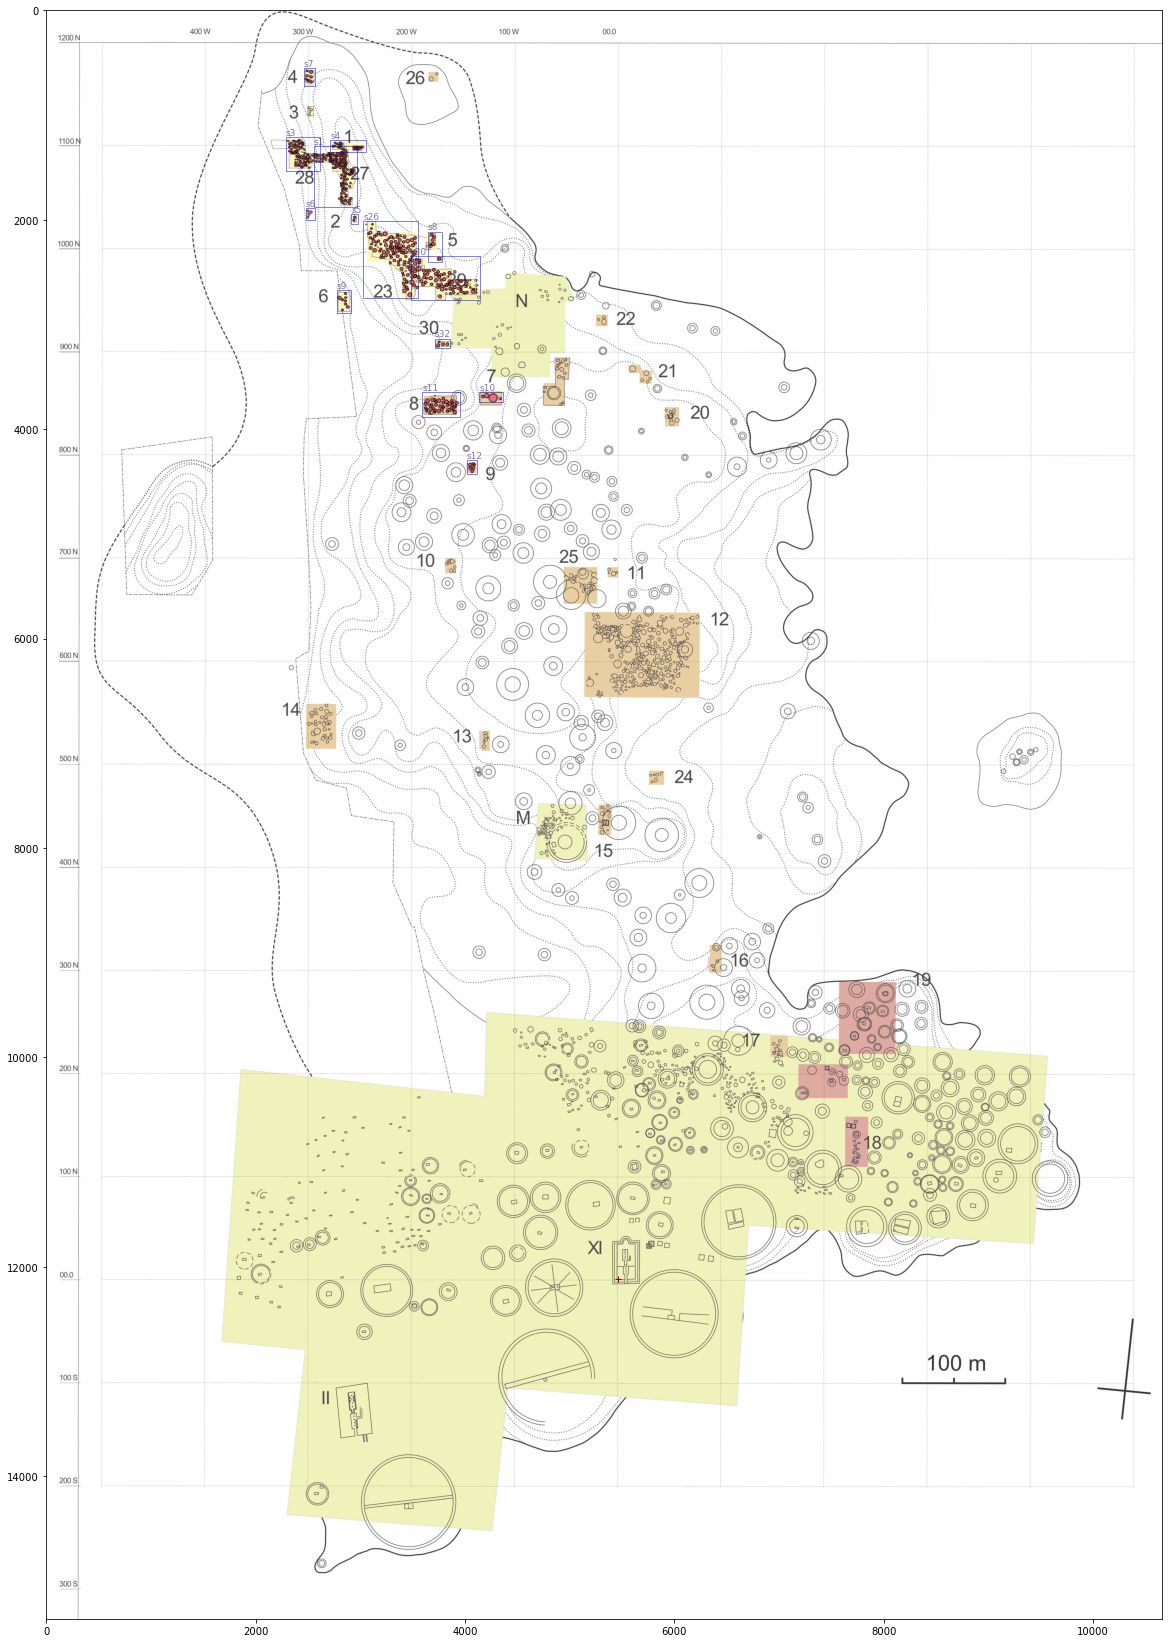

In [325]:
plt.figure(figsize = (20,30))  # (12,18)

x0 = 5465
y0 = 12120

plt.plot(x0, y0, marker='+', color="DarkRed")


color = 'Crimson'
plt.scatter(x=x, y=y, c=color, s=s , alpha = 0.6, linewidths=0.8, edgecolors='black')

for r in rectangles:    
    plt.gca().add_patch(Rectangle(r[0], r[1], r[2],edgecolor='blue',
                    facecolor='none',
                    lw=0.7, alpha=0.7))
for i in rectangles:
    plt.annotate(('s'+ str(i[3])),(i[0][0],i[0][1]-20), alpha=0.7, fontsize=9, color='DarkSlateBlue')

# https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html
implot = plt.imshow(im, alpha=0.8)

# plt.savefig('documentation/carte_necropole_avec_tombes.jpg', format='jpg')
plt.savefig('documentation/carte_necropole_avec_tombes.svg', format='svg')

# plt.show()

### Remarques

* Ouvrir l'image au format .svg enregistrée dans un navigateur afin de l'inspecter plus aisément
* Apparemment les secteurs de la base de données et ceux de l'image ne correspondent pas dans tous les cas, par ex. le secteur 6